In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load datasets
fake_df = pd.read_csv('/Fake.csv')
true_df = pd.read_csv('/True.csv')

# Label the data: 0 for fake, 1 for true
fake_df['label'] = 0
true_df['label'] = 1

# Combine datasets
combined_df = pd.concat([fake_df[['text', 'label']], true_df[['text', 'label']]], ignore_index=True)

# Shuffle data
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Split into features and labels
X = combined_df['text']
y = combined_df['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Check the shape of the data
print(X_train_tfidf.shape, X_test_tfidf.shape)


(35918, 10000) (8980, 10000)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# FNNet model architecture
def fnnnet_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

# Define model
fnnnet = fnnnet_model(X_train_tfidf.shape[1])

# Compile model
fnnnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
fnnnet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5284865 (20.16 MB)
Trainable params: 52848

In [14]:
# Train the FNNet model
history = fnnnet.fit(X_train_tfidf, y_train, epochs=50, batch_size=64, validation_data=(X_test_tfidf, y_test))

# Evaluate the model
loss, accuracy = fnnnet.evaluate(X_test_tfidf, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/50
562/562 [==============================] - 11s 18ms/step - loss: 0.0794 - accuracy: 0.9733 - val_loss: 0.0311 - val_accuracy: 0.9884
Epoch 2/50
562/562 [==============================] - 9s 16ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0335 - val_accuracy: 0.9900
Epoch 3/50
562/562 [==============================] - 9s 16ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0545 - val_accuracy: 0.9861
Epoch 4/50
562/562 [==============================] - 9s 16ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0412 - val_accuracy: 0.9903
Epoch 5/50
562/562 [==============================] - 9s 16ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0432 - val_accuracy: 0.9910
Epoch 6/50
562/562 [==============================] - 9s 16ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0555 - val_accuracy: 0.9898
Epoch 7/50
562/562 [==============================] - 9s 16ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0554 - val_accuracy: 0.991

In [15]:
# Function to preprocess and predict a single news article
def predict_news(news_text, model, vectorizer):
    # Preprocess and vectorize the input news text
    news_vectorized = vectorizer.transform([news_text]).toarray()

    # Predict whether the news is fake (0) or true (1)
    prediction = model.predict(news_vectorized)

    # Interpret the prediction
    if prediction >= 0.5:
        return "True News"
    else:
        return "Fake News"

# Example news to test
test_news = "The state government is nearing the final stages of selecting a site for Bengaluru's second international airport, with the location likely to be near Nelamangala. After thorough evaluation, the area between Nelamangala and Kunigal, along National Highway 75, has been identified as the most suitable for the new airport, according to sources."

# Call the prediction function
result = predict_news(test_news, fnnnet, vectorizer)
print(f"The news is: {result}")


1/1 [==============================] - 0s 113ms/step
The news is: Fake News


In [16]:
import matplotlib.pyplot as plt

# Variables to store training and validation metrics
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Train for 5 epochs
epochs = 5
history = fnnnet.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=64, validation_data=(X_test_tfidf, y_test)) # Use Keras's fit method for training

# Extract metrics from the history object
train_accuracies = history.history['accuracy']
train_losses = history.history['loss']
val_accuracies = history.history['val_accuracy']
val_losses = history.history['val_loss']

# Print metrics for each epoch
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train loss: {train_losses[epoch]:.4f}, Train accuracy: {train_accuracies[epoch]:.4f}')
    print(f'Validation loss: {val_losses[epoch]:.4f}, Validation accuracy: {val_accuracies[epoch]:.4f}')

Epoch 1/5
562/562 [==============================] - 10s 18ms/step - loss: 3.2924e-04 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 0.9923
Epoch 2/5
562/562 [==============================] - 9s 17ms/step - loss: 3.2066e-04 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 0.9921
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 2.2012e-04 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9922
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 3.0986e-04 - accuracy: 1.0000 - val_loss: 0.1004 - val_accuracy: 0.9924
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 4.2109e-04 - accuracy: 1.0000 - val_loss: 0.0936 - val_accuracy: 0.9919
Epoch 1/5
Train loss: 0.0003, Train accuracy: 1.0000
Validation loss: 0.0985, Validation accuracy: 0.9923
Epoch 2/5
Train loss: 0.0003, Train accuracy: 1.0000
Validation loss: 0.0931, Validation accuracy: 0.9921
Epoch 3/5
Train loss: 0.0002, Train accuracy: 1.0000
Vali

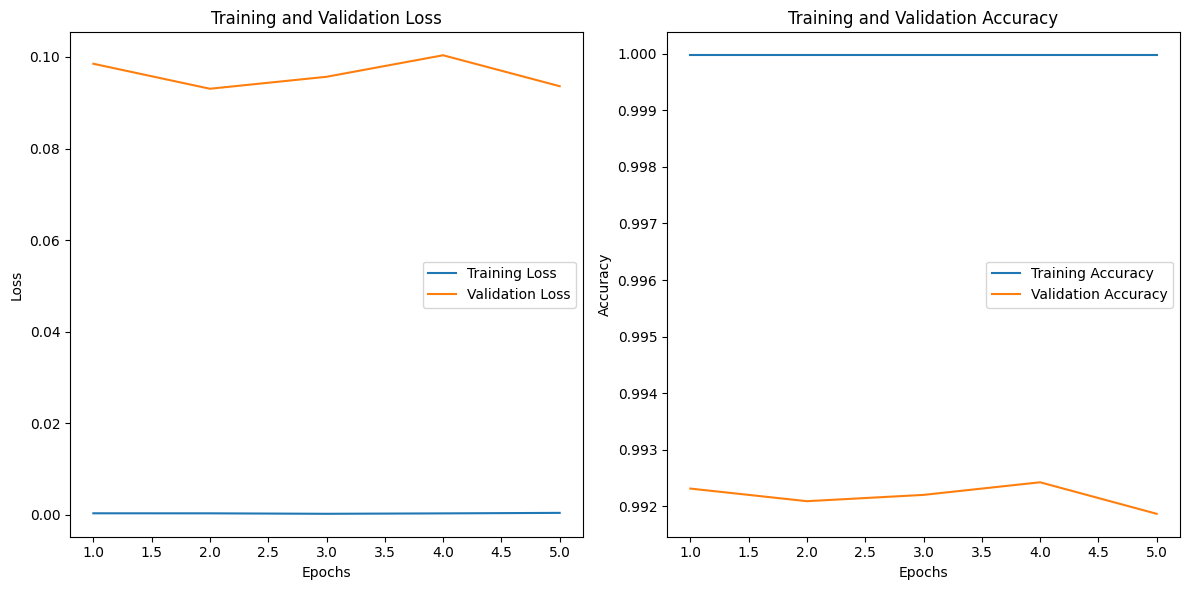

In [17]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import classification_report
import numpy as np


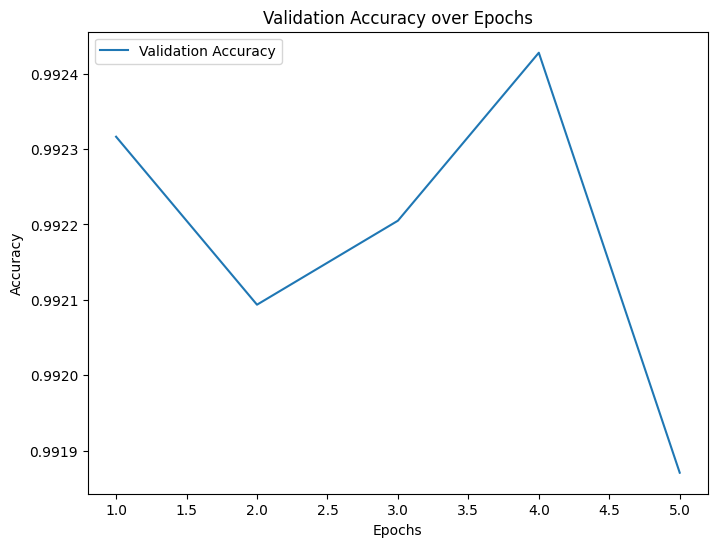

In [21]:
# Plot the validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()


In [24]:
user_input = input("Enter the news article: ")

result = predict_news(user_input, fnnnet, vectorizer)
print(f"The news is: {result}")


Enter the news article: Fred Rogers served as a sniper during the Vietnam War and had a large number of confirmed kills. Fred Rogers wore his iconic sweaters to conceal the extensive tattoos on his arms that were acquired while serving in the military.
1/1 [==============================] - 0s 28ms/step
The news is: Fake News


In [25]:
user_input = input("Enter the news article: ")

result = predict_news(user_input, fnnnet, vectorizer)
print(f"The news is: {result}")


Enter the news article: WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBIâ€™s decision to open a counter-intelligence investigation of Moscowâ€™s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadop

In [26]:
user_input = input("Enter the news article: ")

result = predict_news(user_input, fnnnet, vectorizer)
print(f"The news is: {result}")


Enter the news article: The state government is nearing the final stages of selecting a site for Bengaluru's second international airport, with the location likely to be near Nelamangala. After thorough evaluation, the area between Nelamangala and Kunigal, along National Highway 75, has been identified as the most suitable for the new airport, according to sources.
1/1 [==============================] - 0s 29ms/step
The news is: Fake News


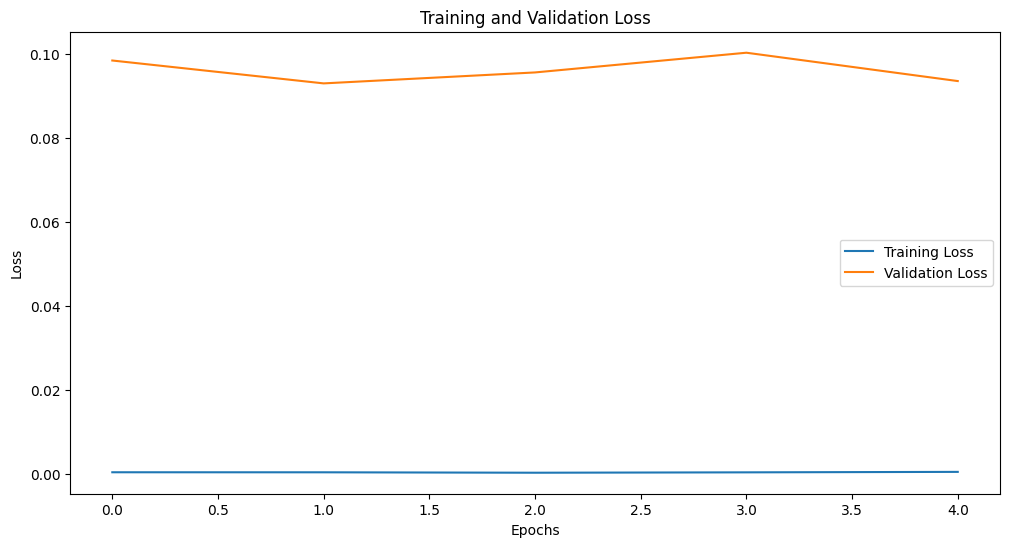

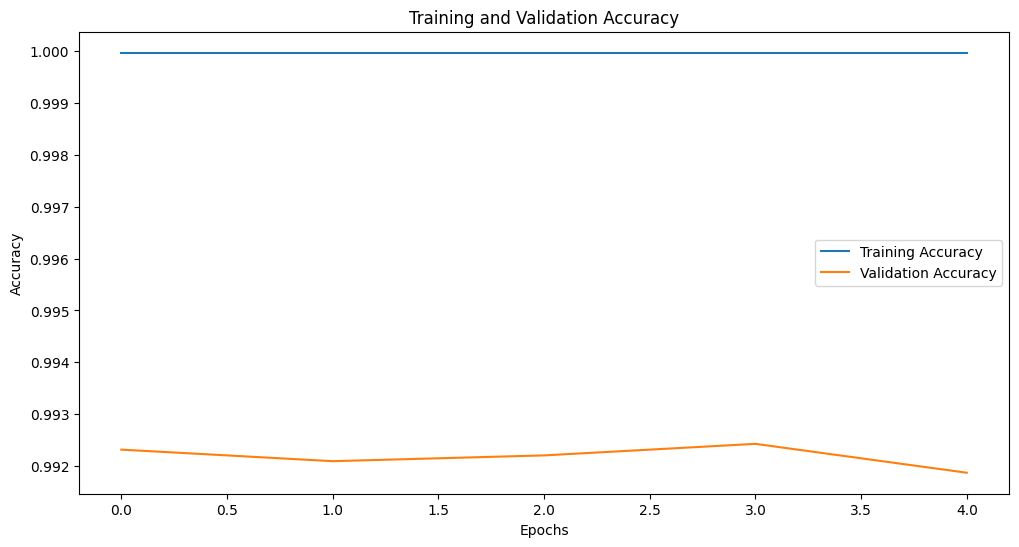

281/281 [==============================] - 1s 3ms/step


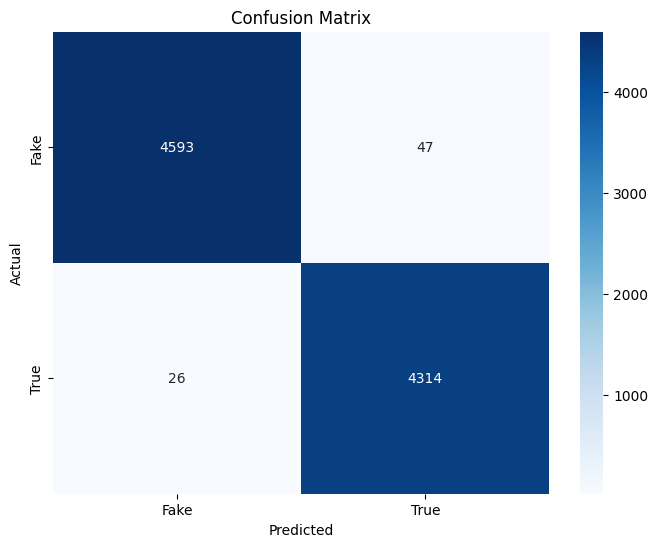

281/281 [==============================] - 1s 3ms/step


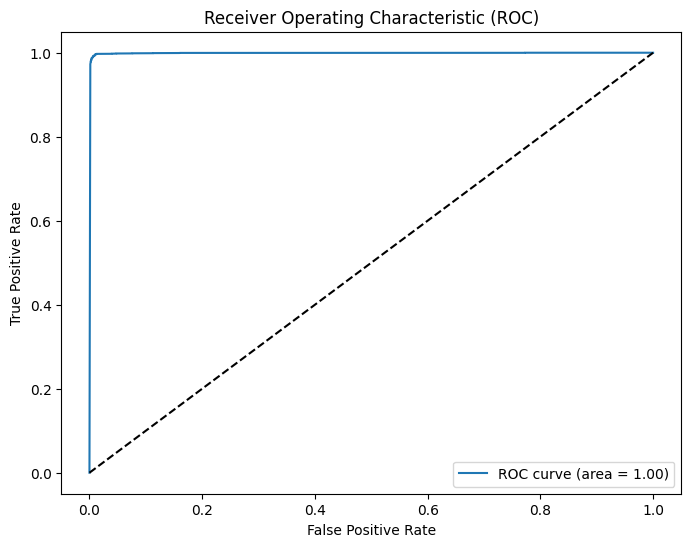

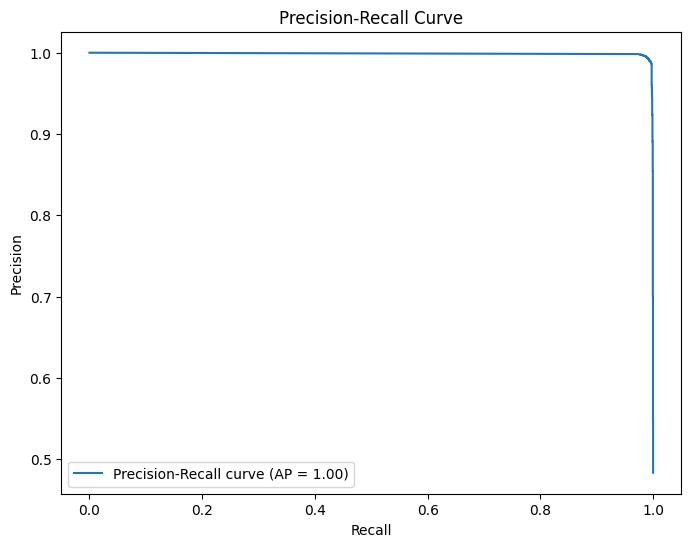

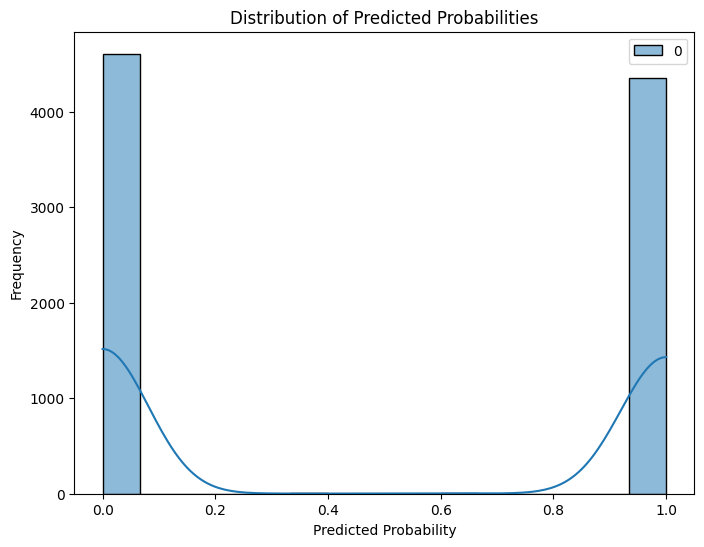

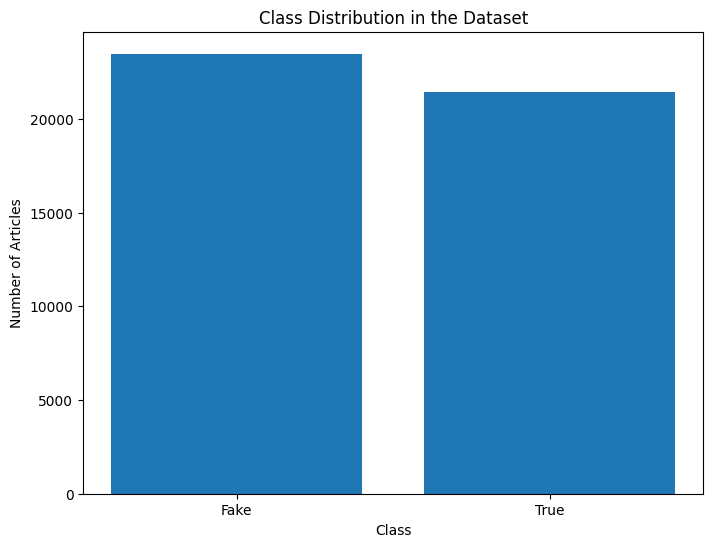

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 2. Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 3. Plot Confusion Matrix (requires predictions on test data)
from sklearn.metrics import confusion_matrix

y_pred = (fnnnet.predict(X_test_tfidf) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Plot ROC Curve (requires predictions on test data)
from sklearn.metrics import roc_curve, auc

y_pred_proba = fnnnet.predict(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 5. Plot Precision-Recall Curve (requires predictions on test data)
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 6. Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# 7. Bar plot of class distribution in the dataset
class_counts = combined_df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(['Fake', 'True'], class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Articles')
plt.title('Class Distribution in the Dataset')
plt.show()






281/281 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4640
           1       0.99      0.99      0.99      4340

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



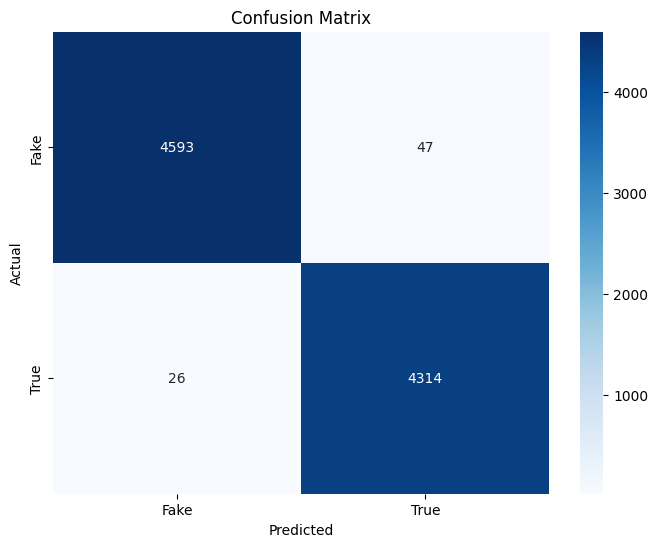

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_proba = fnnnet.predict(X_test_tfidf)

# Convert probabilities to class labels (0 or 1) using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
